<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [4]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential, Model
from keras.applications import vgg16, mobilenet, resnet, xception
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from random import seed
from random import randint
from keras import layers
import seaborn as sns

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical")
])

# Función para mostrar lista de imágenes en escala de grises
def show_row_of_gray_images(fig_width, *images):
    plt.figure(figsize=(fig_width, fig_width))
    images_count = len(images)
    index = 1  
    for image in images:
        plt.subplot(1, images_count, index)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        index+=1

# Función para añadir datos a una tebla de excel
def append_data_to_excel(excel_name, df):
    with pd.ExcelWriter(excel_name,
        mode="a",
        engine="openpyxl",
        if_sheet_exists="overlay") as writer:
        start_row = 0
        header = True
        if os.path.exists(excel_name):
            df_source = pd.read_excel(excel_name, engine="openpyxl").iloc[:,1:]
        if df_source is not None:
            n, m = df_source.shape
            header = False if n > 0 else True
            start_row = n + 1 if n > 0 else n
        
        df.to_excel(writer, sheet_name="Sheet1",startcol=0, startrow = start_row, header=header)

# Función para graficar progreso durante el entrenamiento de la red 
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label = 'Validación')
    plt.xlabel('Iteración (epoch)')
    plt.ylabel('Exactitud (accuracy)')
    plt.ylim([0, 1])
    plt.grid()
    plt.title('Modelo '+str(i+1))
    plt.legend(loc='lower right')

#Distintas arquitectura para salida de la red neuronal
def cnn1(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(classes, activation='softmax'))   
    return model

def cnn2(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(classes, activation='softmax'))
    return model

def cnn3(_input_shape, classes):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(classes, activation='softmax'))
    return model

def get_base_model(name, input_size):
    if name == 'vgg':
        return vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))
    elif name == 'mobilnet':
        return mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))
    elif name == 'xception':
        return xception.Xception(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))
    else: return resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(input_size,input_size,3))


#### Lectura de los datos:

386
192
43


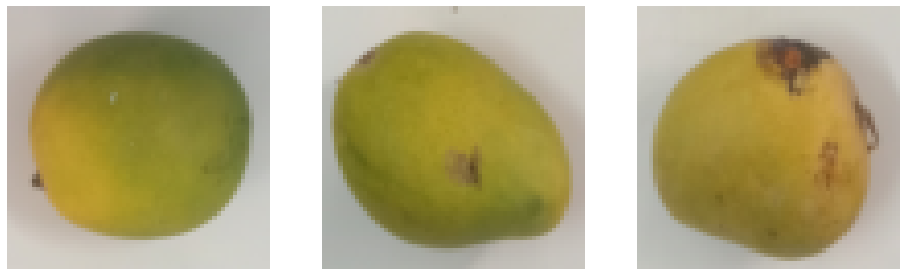

In [5]:
# seed random number generator
seed(1)

# Dimensión de entrada de las imágenes 
IMG_SIZE = 64
h = IMG_SIZE
w = IMG_SIZE

# Leer los nombres de las imágenes para importarlas
input_class1_path = "./Dataset/Grading_dataset/Class_I"
class1_names = os.listdir(input_class1_path)
input_class2_path = "./Dataset/Grading_dataset/Class_II"
class2_names = os.listdir(input_class2_path)
input_classex_path = "./Dataset/Grading_dataset/Extra_Class"
class3_names = os.listdir(input_classex_path)

# Número de elementos en cada clase
n = len(class1_names)

# Definir listas para cargar imágenes
class1 = np.ones([n, h, w, 3])
class2 = np.ones([n, h, w, 3])
class0 = np.ones([n, h, w, 3])

for i in range(0, n, 1):
    # Para cada clase, se lee una imágen, se importa
    img = resize(imread("./Dataset/Grading_dataset/Class_I/" + class1_names[i]), (h, w))
    class1[i] = img  
    img = resize(imread("./Dataset/Grading_dataset/Class_II/" + class2_names[i]), (h, w))
    class2[i] = img 
    img = resize(imread("./Dataset/Grading_dataset/Extra_Class/" + class3_names[i]), (h, w))
    class0[i] = img 

# Aumentamos por un factor f el número de datos de cada clase
f = 5
class0_augmeted = np.zeros([n * f, h, w, 3])
t0 = np.zeros(n * f)
t1 = np.ones(n)
t2 = np.ones(n) * 2

for i in range(n * f):
    rn = randint(0, n-1)
    img = class0[rn]
    new_img = data_augmentation(img)
    class0_augmeted [i] = new_img


# Se imprimen tres imágenes aleatorias de los datos aumentados para comprobar que funciona    
limit1 = len(class0_augmeted)
rn = randint(0, limit1 - 1)
img_1 = class0_augmeted[rn]
print (rn)

limit2 = len(class1)
rn = randint(0, limit2 - 1)
img_2 = class1[rn]
print (rn)

limit3 = len(class2)
rn = randint(0, limit3 - 1)
img_3 = class2[rn]  
print (rn)

show_row_of_gray_images(16, img_1, img_2, img_3)


X_train_val, X_test, t_train_val, t_test = train_test_split(class0_augmeted, t0, test_size=0.25, shuffle=True)
X_train, X_val, t_train, t_val = train_test_split(X_train_val, t_train_val, test_size=0.3, shuffle=True)
X_c1_train, X_c1_test, t_c1_train, t_c1_test = train_test_split(class1, t1, test_size=0.25, shuffle=True)
X_c2_train, X_c2_test, t_c2_train, t_c2_test = train_test_split(class2, t2, test_size=0.25, shuffle=True)

scaler = StandardScaler()
x_train_scaled = (scaler.fit_transform(X_train.reshape(len(X_train), IMG_SIZE * IMG_SIZE * 3))).reshape(len(X_train), IMG_SIZE, IMG_SIZE, 3)
x_valid_scaled = scaler.transform(X_val.reshape(len(X_val), IMG_SIZE * IMG_SIZE * 3)).reshape(len(X_val), IMG_SIZE, IMG_SIZE, 3)
x_test_scaled = scaler.transform(X_test.reshape(len(X_test), IMG_SIZE * IMG_SIZE * 3)).reshape(len(X_test), IMG_SIZE, IMG_SIZE, 3)
x_c1_test_scaled = scaler.transform(X_c1_test.reshape(len(X_c1_test), IMG_SIZE * IMG_SIZE * 3)).reshape(len(X_c1_test), IMG_SIZE, IMG_SIZE, 3)
x_c2_test_scaled = scaler.transform(X_c2_test.reshape(len(X_c2_test), IMG_SIZE * IMG_SIZE * 3)).reshape(len(X_c2_test), IMG_SIZE, IMG_SIZE, 3)

test_data = np.concatenate((x_test_scaled, X_c1_test, X_c2_test), axis = 0)
test_t = np.concatenate((t_test, t_c1_test, t_c2_test), axis = 0)

train_target = tf.keras.utils.to_categorical(t_train)
val_target = tf.keras.utils.to_categorical(t_val)
test_target = tf.keras.utils.to_categorical(t_test)

In [63]:
encoded_dim = 32
IMG_SIZE = 64

encoder = Sequential([
    layers.Conv2D(input_shape=(IMG_SIZE,IMG_SIZE,3), filters= 64, kernel_size = (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D( (2, 2), padding='same'),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D( (2, 2), padding='same'),
    Flatten(),
    Dense(encoded_dim, activation = 'relu')
])

decoder = Sequential ([
    Dense(1024, activation = 'relu', input_shape=(encoded_dim,)),
    layers.Reshape((8,8,16)),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D( (2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D( (2, 2)),
    layers.Conv2D(3, (3, 3), activation='linear', padding='same')
])

epochs = 150
batch_size = 40
autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
autoencoder_dr.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ["mean_squared_error"])
history = autoencoder_dr.fit(x_train_scaled, x_train_scaled, validation_data = (x_valid_scaled, x_valid_scaled), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
 1/14 [=>............................] - ETA: 30s - loss: 0.9436 - mean_squared_error: 0.9436

KeyboardInterrupt: 

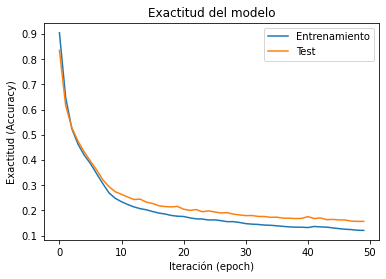

In [60]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud (Accuracy)')
plt.xlabel('Iteración (epoch)')
plt.legend(['Entrenamiento', 'Test'], loc='upper right')
plt.show()

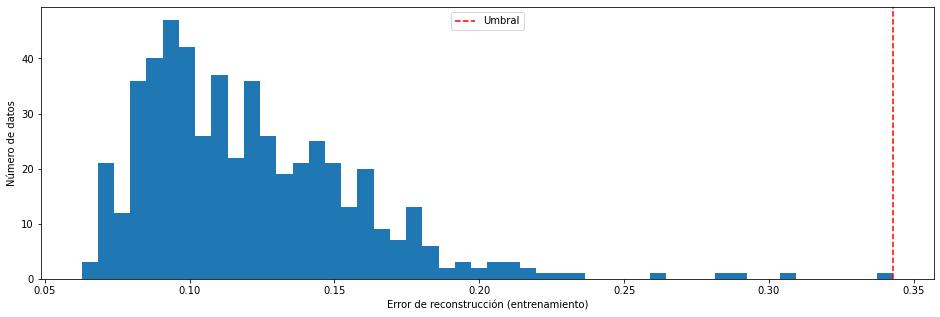

In [61]:
e_train = autoencoder_dr.predict(x_train_scaled).reshape(len(x_train_scaled),IMG_SIZE*IMG_SIZE*3)
x_train_reshaped = x_train_scaled.reshape(len(x_train_scaled),IMG_SIZE*IMG_SIZE*3)
mse_train = np.mean(np.power(x_train_reshaped - e_train, 2), axis=1)
umbral = np.max(mse_train)


plt.figure(figsize=(16,5))
plt.hist(mse_train, bins = 50)
plt.xlabel("Error de reconstrucción (entrenamiento)")
plt.ylabel("Número de datos")
plt.axvline(umbral, color='r', linestyle='--')
plt.legend(["Umbral"], loc="upper center");

#### Finalmente se realiza la clasificación utilizando las capas finales de la red

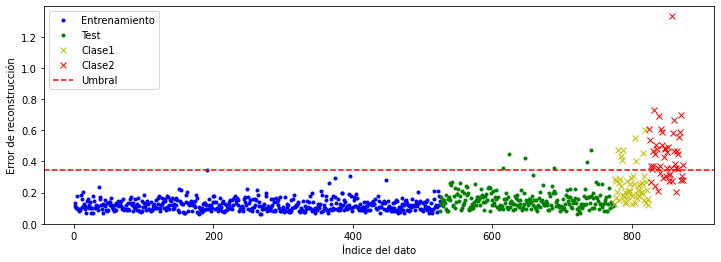

In [62]:
tic = time.perf_counter()
e_test = autoencoder_dr.predict(x_test_scaled).reshape(len(x_test_scaled),IMG_SIZE*IMG_SIZE*3)
class0_reshaped = x_test_scaled.reshape(len(x_test_scaled),IMG_SIZE*IMG_SIZE*3)
mse_test0 = np.mean(np.power(class0_reshaped - e_test, 2), axis=1)
false_alarms = len(mse_test0[mse_test0 > umbral])/len(mse_test0)

e_test = autoencoder_dr.predict(x_c1_test_scaled).reshape(len(x_c1_test_scaled),IMG_SIZE*IMG_SIZE*3)
class1_reshaped = x_c1_test_scaled.reshape(len(x_c1_test_scaled),IMG_SIZE*IMG_SIZE*3)
mse_test1 = np.mean(np.power(class1_reshaped - e_test, 2), axis=1)
faults1_ignored = len(mse_test1[mse_test1 < umbral])/len(mse_test1)

e_test = autoencoder_dr.predict(x_c2_test_scaled).reshape(len(x_c2_test_scaled),IMG_SIZE*IMG_SIZE*3)
class2_reshaped = x_c2_test_scaled.reshape(len(x_c2_test_scaled),IMG_SIZE*IMG_SIZE*3)
mse_test2 = np.mean(np.power(class2_reshaped - e_test, 2), axis=1)
faults2_ignored = len(mse_test2[mse_test2 < umbral])/len(mse_test2)
toc = time.perf_counter()

err = ((false_alarms + faults1_ignored + faults2_ignored)/ 
      (len(X_test) + len(X_c1_test) + len(X_c2_test)))

plt.figure(figsize=(12,4))
plt.plot(range(1,x_train_reshaped.shape[0]+1),mse_train,'b.')
limit1 = x_train_reshaped.shape[0] + class0_reshaped.shape[0]
limit2 = limit1 + class1_reshaped.shape[0]
limit3 = limit2 + class2_reshaped.shape[0]
plt.plot(range(x_train_reshaped.shape[0], limit1),mse_test0,'g.')
plt.plot(range(limit1,limit2),mse_test1,'yx')
plt.plot(range(limit2,limit3),mse_test2,'rx')
plt.axhline(umbral, color='r', linestyle='--')
plt.xlabel('Índice del dato')
plt.ylabel('Error de reconstrucción');
plt.legend(["Entrenamiento", "Test", "Clase1", "Clase2", 'Umbral'], loc="upper left");

In [25]:
eval_time = round((toc-tic), 2)
test_data = {'model':autoencoder_dr._name,
        'input_dim': str(IMG_SIZE) + 'x' + str(IMG_SIZE),
        'encoder_dim': str(encoded_dim) + 'x' + str(encoded_dim),
        'epochs': epochs,
        'batch_size': batch_size,
        'false_alarms': false_alarms,
        'faults1_ignored': faults1_ignored,
        'faults2_ignored': faults2_ignored,
        'eval time': eval_time
        }


now = datetime.now() # current date and time       
time_ = {now.strftime("%d/%m/%Y %H:%M:%S")}
df = pd.DataFrame(test_data, index = time_)
excel_name = "./informe/tables/FaultDetection.xlsx"
append_data_to_excel(excel_name, df)
print(df)

                       model input_dim encoder_dim  epochs  batch_size  \
09/05/2022 11:41:55  model_5     64x64     512x512     150          50   

                     false_alarms  faults1_ignored  faults2_ignored  eval time  
09/05/2022 11:41:55          0.38              0.0              0.0       2.86  


model_6
(64, 64, 3)
(1, 64, 64, 3)


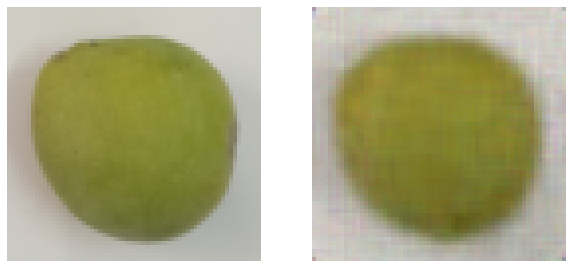

In [43]:
print(autoencoder_dr.name)
img = X_test[0]
img_y = autoencoder_dr(np.expand_dims(img,axis=0))
print(img.shape)
print(img_y.shape)
show_row_of_gray_images(10, img, img_y[0])

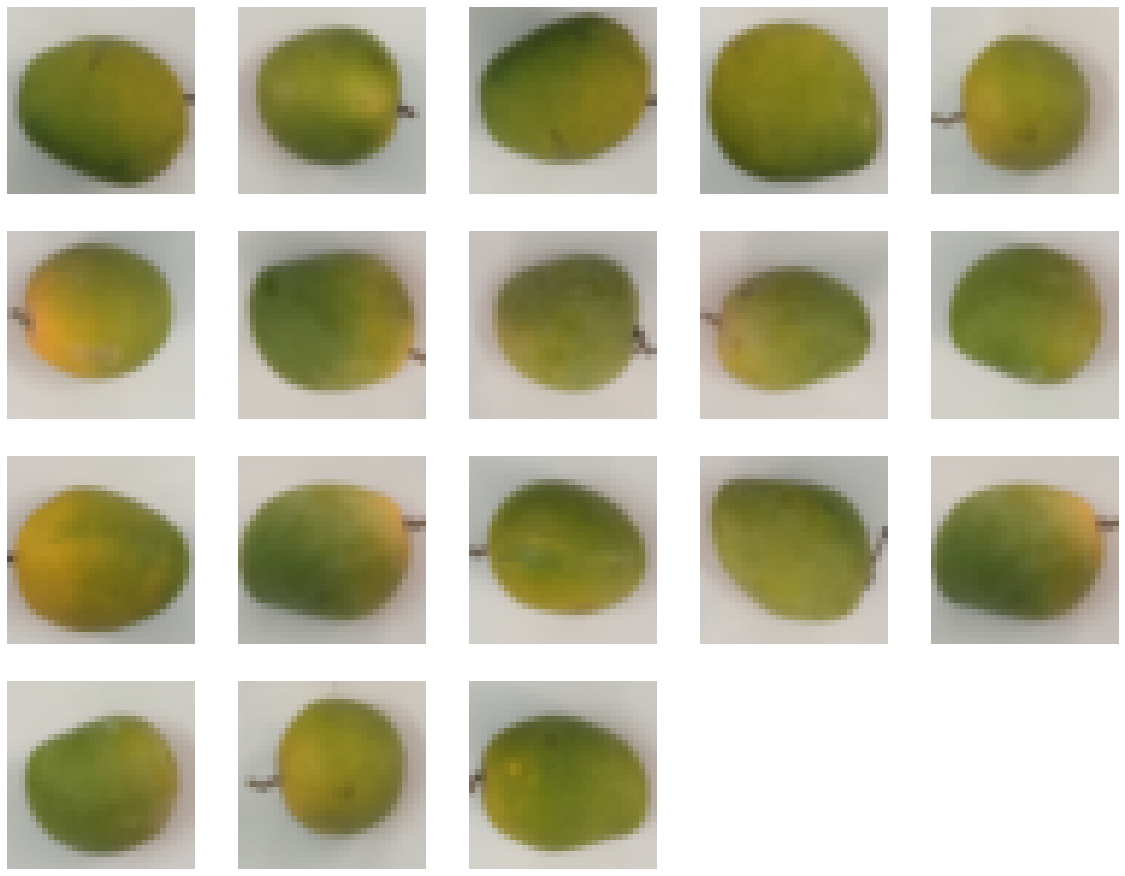

In [68]:
normal2show = X_test[mse_test0>umbral]
images_count = len(normal2show)
plt.figure(figsize=(20, 20))
for i in range(0, images_count):
        plt.subplot(round(images_count/5) + 1, 5, i + 1)
        plt.imshow(normal2show[i], cmap='gray')
        plt.axis('off')

#### Se puede calcular la matriz de confusión de la red

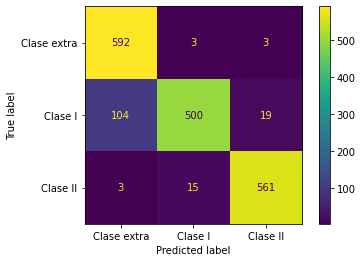

In [38]:
Clases=['Clase extra','Clase I','Clase II']
features_test = pretrained_model.predict(X_test.reshape(len(X_test),IMG_SIZE,IMG_SIZE,3))
t_pred = []
for i in range(0,len(features_test)):
    t_pred.append(np.argmax(modelCNN.predict(features_test[i:i+1])))
cm = confusion_matrix(t_test, t_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Clases)
disp.plot()

In [37]:

stored_accuracy = history.history['accuracy'][-5:]

%store stored_accuracy

Stored 'stored_accuracy' (list)
